In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from neo4j import GraphDatabase

# Neo4j configuration
URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "Shady5000$")

In [518]:

class UAVNetworkSimulation:

    def __init__(self, uri, auth):
        self.driver = GraphDatabase.driver(uri, auth=auth)

    def close(self):
        self.driver.close()
    
    def create_initial_graph(self, num_uavs, connection_range, ground_station_pos, backbone_range):
        G = nx.Graph()

        # Add UAV nodes
        # for i in range(num_uavs):
        #     G.add_node(i, pos=(random.randint(0, 100), random.randint(0, 100)))
        # Define typical throughput and latency ranges (for example purposes)
        typical_throughput = (50, 100)  # Mbps
        typical_latency = (10, 50)     # Milliseconds

        # Add UAV nodes with properties
        for i in range(num_uavs):
            throughput = random.randint(*typical_throughput)
            latency = random.randint(*typical_latency)
            G.add_node(i, pos=(random.randint(0, 100), random.randint(0, 100)),
                       throughput=throughput, latency=latency)

        # Add Backbone UAV
        backbone_uav_id = num_uavs
        G.add_node(backbone_uav_id, pos=(random.randint(0, 100), random.randint(0, 100)), is_backbone=True,
                       throughput=throughput, latency=latency)

        # Connect Backbone UAV to other UAVs
        for i in range(num_uavs):
            pos_i = G.nodes[i]['pos']
            pos_backbone = G.nodes[backbone_uav_id]['pos']
            distance = np.linalg.norm(np.array(pos_i) - np.array(pos_backbone))
            if distance <= backbone_range:
                G.add_edge(i, backbone_uav_id, weight=distance)

        # Add and connect the Ground Station
        ground_station_id = num_uavs + 1
        G.add_node(ground_station_id, pos=ground_station_pos, is_ground_station=True, throughput=throughput, latency=latency)
        G.add_edge(backbone_uav_id, ground_station_id)

        # Add edges between UAVs within connection range
        for i in range(num_uavs):
            for j in range(i + 1, num_uavs):
                pos_i = G.nodes[i]['pos']
                pos_j = G.nodes[j]['pos']
                distance = np.linalg.norm(np.array(pos_i) - np.array(pos_j))
                if distance <= connection_range:
                    G.add_edge(i, j, weight=distance)

        return G

    def upload_to_neo4j(self, G):
        with self.driver.session() as session:
            # Clear existing data
            session.run("MATCH (n) DETACH DELETE n")

            # Add nodes
            for node in G.nodes:
                is_backbone = G.nodes[node].get('is_backbone', False)
                is_ground_station = G.nodes[node].get('is_ground_station', False)
                is_attack_node = G.nodes[node].get('is_attack_node', False)

                if is_backbone:
                    session.run(f"""
                        CREATE (b:BackboneUAV {{id: $id, pos: $pos, uavType: $uavType,
                            throughput: $throughput, latency: $latency}})
                        """, id=node, pos=G.nodes[node]['pos'], uavType = "Backbone UAV", throughput=G.nodes[node]['throughput'],
                        latency=G.nodes[node]['latency'])
                elif is_ground_station:
                    session.run(f"""
                        CREATE (g:GroundStation {{id: $id, pos: $pos, gsName: $GS}})
                        """, id=node, pos=G.nodes[node]['pos'], GS = "Ground Station")
                else:
                    session.run(f"""
                        CREATE (u:UAV {{id: $id, pos: $pos, uavType: $uavType, uavName: $uavName,
                            throughput: $throughput + 'mb/s', latency: $latency + 'ms'}})
                        """, id=node, pos=G.nodes[node]['pos'], uavType = "UAV", uavName = "UAV"  + str(node), throughput=G.nodes[node]['throughput'],
                        latency=G.nodes[node]['latency'])

            # Add relationships
            for source, target in G.edges:
                session.run("""
                    MATCH (a), (b)
                    WHERE a.id = $source AND b.id = $target
                    CREATE (a)-[:COMMUNICATES_WITH]->(b)
                    """, source=source, target=target)


    def draw_graph(self, G):
        pos = nx.get_node_attributes(G, 'pos')

        # Prepare custom labels
        labels = {}
        for node in G.nodes:
            if G.nodes[node].get('is_backbone', False):
                labels[node] = 'Backbone UAV'
            elif G.nodes[node].get('is_ground_station', False):
                labels[node] = 'Ground Station'
            elif G.nodes[node].get('is_attack_node', False):
                labels[node] = 'Attack Node'
            else:
                labels[node] = f'UAV{node}'

        # Differentiate node types
        regular_nodes = [node for node in G.nodes if not G.nodes[node].get('is_backbone', False) and not G.nodes[node].get('is_ground_station', False)]
        backbone_nodes = [node for node in G.nodes if G.nodes[node].get('is_backbone', False)]
        ground_station_nodes = [node for node in G.nodes if G.nodes[node].get('is_ground_station', False)]
        attacking_nodes = [node for node in G.nodes if G.nodes[node].get('is_attack_node', False)]

        # Draw regular UAV nodes
        nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color='lightblue', node_size=300, label='UAV')
        
        # Draw backbone UAV node
        nx.draw_networkx_nodes(G, pos, nodelist=backbone_nodes, node_color='green', node_size=500, label='Backbone UAV')

        # Draw ground station node
        nx.draw_networkx_nodes(G, pos, nodelist=ground_station_nodes, node_color='red', node_size=500, label='Ground Station')

        nx.draw_networkx_nodes(G, pos, nodelist=attacking_nodes, node_color='red', node_size=500, label='Attack Node')

        # Draw edges
        nx.draw_networkx_edges(G, pos, edge_color='gray')

        # Draw custom labels
        nx.draw_networkx_labels(G, pos, labels)

        plt.title("UAV Network with Backbone UAV and Ground Station")
        plt.legend()
        plt.show()
        
    def update_uav_positions(self, G, move_range):
        """
        Update the positions of UAVs randomly within a given range.
        """
        for node in G.nodes:
            if 'is_backbone' not in G.nodes[node] and 'is_ground_station' not in G.nodes[node]:
                current_pos = G.nodes[node]['pos']
                new_pos = (current_pos[0] + random.uniform(-move_range, move_range), 
                           current_pos[1] + random.uniform(-move_range, move_range))
                G.nodes[node]['pos'] = new_pos
        return G

    def update_network_connections(self, G, connection_range, backbone_range):
        """
        Update the network connections based on new positions and connection range.
        """
        num_uavs = len(G.nodes) - 2  # Excluding backbone UAV and ground station
        backbone_uav_id = num_uavs

        # Update connections for regular UAVs
        for i in range(num_uavs):
            for j in range(i + 1, num_uavs):
                if G.has_edge(i, j):
                    G.remove_edge(i, j)
                pos_i = G.nodes[i]['pos']
                pos_j = G.nodes[j]['pos']
                distance = np.linalg.norm(np.array(pos_i) - np.array(pos_j))
                if distance <= connection_range:
                    G.add_edge(i, j, weight=distance)

        # Update connections for the Backbone UAV
        for i in range(num_uavs):
            if G.has_edge(i, backbone_uav_id):
                G.remove_edge(i, backbone_uav_id)
            pos_i = G.nodes[i]['pos']
            pos_backbone = G.nodes[backbone_uav_id]['pos']
            distance = np.linalg.norm(np.array(pos_i) - np.array(pos_backbone))
            if distance <= backbone_range:
                G.add_edge(i, backbone_uav_id, weight=distance)

        return G

    def update_neo4j_database(self, G):
        """
        Update the Neo4j database with the new positions and connections.
        """
        with self.driver.session() as session:
            # Update positions
            for node in G.nodes:
                pos = G.nodes[node]['pos']
                session.run("""
                    MATCH (n)
                    WHERE n.id = $id
                    SET n.pos = $pos
                    """, id=node, pos=pos)

            # Update relationships
            session.run("MATCH (n)-[r:COMMUNICATES_WITH]->() DELETE r")
            for source, target in G.edges:
                session.run("""
                    MATCH (a), (b)
                    WHERE a.id = $source AND b.id = $target
                    CREATE (a)-[:COMMUNICATES_WITH]->(b)
                    """, source=source, target=target)
    
    def generate_network_traffic(self, G, num_packets):
        """
        Generate network traffic considering the throughput of UAVs.
        """
        packets = []
        for _ in range(num_packets):
            source = random.randint(0, len(G.nodes) - 3)  # Exclude backbone and ground station
            target = random.randint(0, len(G.nodes) - 3)
            
            #Packet size should not exceed the throughput of the source UAV
            max_packet_size = G.nodes[source]['throughput']
            size = random.randint(1, max_packet_size)

            packets.append({'source': source, 'target': target, 'size': size})
        return packets
    
    def route_packets(self, G, packets):
        """
        Determine the path for each packet and calculate cumulative latency.
        """
        for packet in packets:
            source = packet['source']
            target = packet['target']
            if nx.has_path(G, source, target):
                path = nx.shortest_path(G, source, target)
                packet['path'] = path
                packet['delivered'] = True

                # Calculate cumulative latency
                total_latency = sum(G.nodes[node]['latency'] for node in path)
                packet['total_latency'] = total_latency
            else:
                packet['path'] = []
                packet['delivered'] = False
                packet['total_latency'] = None
        return packets


    def add_attack_node(self, G, target_ids, num_uavs, attack_node_pos=(random.randint(0, 100), random.randint(0, 100))):
        # Calculate a new ID for the attack node by taking the maximum current ID + 1
        attack_node_id = max(G.nodes()) + 1
        # Add the attack node with specified properties
        G.add_node(attack_node_id, pos=attack_node_pos, nodeName="Attack Node", is_attack_node=True, throughput=1000, latency=1)

        # Directly connect the attack node to the target node
        for target_id in target_ids:
            if target_id in G.nodes():
                G.add_edge(attack_node_id, target_id, weight=5)  # Weight can be adjusted or calculated based on actual metrics

        return attack_node_id

    def upload_attack_node_to_neo4j(self, G, attack_node_id, target_ids):
        with self.driver.session() as session:
            # Retrieve node data from the graph
            attack_node = G.nodes[attack_node_id]
            # Create the attack node in Neo4j
            session.run("""
                CREATE (a:AttackNode {
                    id: $id, 
                    pos: $pos,
                    nodeName: $nodeName,
                    throughput: $throughput, 
                    latency: $latency, 
                    is_attack_node: $is_attack_node
                })
                """, id=attack_node_id, 
                    pos=str(attack_node['pos']),
                    nodeName=attack_node['nodeName'],
                    throughput=attack_node['throughput'], 
                    latency=attack_node['latency'], 
                    is_attack_node=True)

            # Create a relationship from the attack node to the target UAV
            for target_id in target_ids:
                if target_id in G.nodes():
                    session.run("""
                        MATCH (a:AttackNode {id: $attack_id}), (u:UAV {id: $target_id})
                        CREATE (a)-[:ATTACKS]->(u)
                        """, attack_id=attack_node_id, target_id=target_id)



    def run_simulation(self, G, total_time, update_interval, move_range, connection_range, backbone_range, num_packets):
    
        #Run the simulation for a specified period of time.
            
        start_time = time.time()
        iteration = 0
        while time.time() - start_time < total_time:
            print(f"Iteration {iteration}:")
            iteration += 1
            # Update UAV positions
            self.update_uav_positions(G, move_range)

            # Update network connections
            self.update_network_connections(G, connection_range, backbone_range)

            # Optional: Update Neo4j database and redraw the graph at each step
            # self.update_neo4j_database(G)
            # self.draw_graph(G)
            packets = self.generate_network_traffic(G, num_packets)
            routed_packets = self.route_packets(G, packets)

             # Log the routed packets information
            for i, packet in enumerate(routed_packets):
                print(f"  Packet {i}: Source: {packet['source']}, Target: {packet['target']}, "
                      f"Size: {packet['size']}, Delivered: {packet['delivered']}, "
                      f"Path: {packet['path']}, Total Latency: {packet['total_latency']}")

            # Wait for the next update
            time.sleep(update_interval)

    def simulate_ddos_attack(self, G, attack_node_id, target_ids, increase_factor, decrease_factor):
        for target_id in target_ids:
            if target_id in G.nodes():
                G.nodes[target_id]['latency'] = int(G.nodes[target_id]['latency'] * increase_factor)
                G.nodes[target_id]['throughput'] = int(G.nodes[target_id]['throughput'] * decrease_factor)
                # Apply effects to neighboring nodes, ensuring integer operations
                for neighbor in G.neighbors(target_id):
                    G.nodes[neighbor]['latency'] = int(G.nodes[neighbor]['latency'] * (increase_factor - 0.1))
                    G.nodes[neighbor]['throughput'] = int(G.nodes[neighbor]['throughput'] * (decrease_factor + 0.1))


    def run_ddos_simulation(self, G, total_time, update_interval, move_range, connection_range, backbone_range, num_packets, attack_node_id, target_ids):
        #Run the simulation for a specified period of time.
        import time
        metrics = []  # List to store metrics over time
        start_time = time.time()
        iteration = 0
        while time.time() - start_time < total_time:
            print(f"Iteration {iteration}:")
            iteration += 1

            # Update UAV positions
            self.update_uav_positions(G, move_range)

            # Update network connections
            self.update_network_connections(G, connection_range, backbone_range)

            # Trigger DDoS attack
            if iteration == 1:  # Start the DDoS attack at the first iteration
                self.simulate_ddos_attack(G, attack_node_id, target_ids, 100.5, 0.5)  # Increase latency by 50% and reduce throughput by 50%
                current_metrics = {node: {'latency': G.nodes[node]['latency'], 'throughput': G.nodes[node]['throughput']} for node in G.nodes()}
                print("Current metrics:", current_metrics)
            # Generate and route network traffic
            packets = self.generate_network_traffic(G, num_packets)
            routed_packets = self.route_packets(G, packets)

            # Log the routed packets information
            for i, packet in enumerate(routed_packets):
                print(f"  Packet {i}: Source: {packet['source']}, Target: {packet['target']}, "
                    f"Size: {packet['size']}, Delivered: {packet['delivered']}, "
                    f"Path: {packet['path']}, Total Latency: {packet['total_latency']}")

            # Capture metrics
            current_metrics = {node: {'latency': G.nodes[node]['latency'], 'throughput': G.nodes[node]['throughput']} for node in G.nodes()}
            print("Current metrics:", current_metrics)
            metrics.append((time.time() - start_time, current_metrics))
            # Wait for the next update
            time.sleep(update_interval)
        return metrics


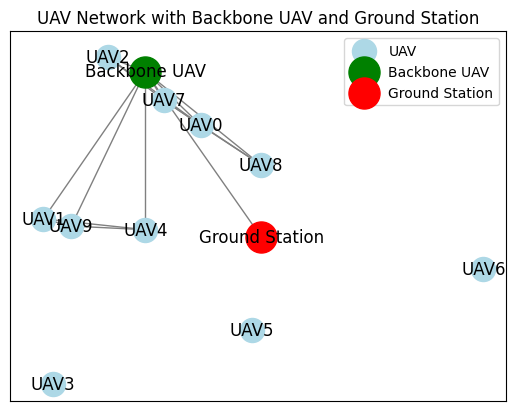

In [519]:
"""Creating The Network First"""
# Simulation Parameters
num_uavs = 10
connection_range = 30
ground_station_pos = (50, 50)
backbone_range = 50
num_packets = 10

total_time = 60  # Total time to run the simulation in seconds
update_interval = 5  # Time interval between updates in seconds
move_range = 5

# Initialize Simulation
simulation = UAVNetworkSimulation(URI, AUTH)

# Create and Setup UAV Network
uav_network = simulation.create_initial_graph(num_uavs, connection_range, ground_station_pos, backbone_range)

# Upload to Neo4j
simulation.upload_to_neo4j(uav_network)

# Draw Initial Graph
simulation.draw_graph(uav_network)

# Close Neo4j Connection
simulation.close()

Iteration 0:
  Packet 0: Source: 8, Target: 1, Size: 42, Delivered: False, Path: [], Total Latency: None
  Packet 1: Source: 5, Target: 2, Size: 60, Delivered: True, Path: [5, 2], Total Latency: 46
  Packet 2: Source: 3, Target: 0, Size: 16, Delivered: False, Path: [], Total Latency: None
  Packet 3: Source: 1, Target: 7, Size: 37, Delivered: True, Path: [1, 10, 7], Total Latency: 66
  Packet 4: Source: 5, Target: 5, Size: 23, Delivered: True, Path: [5], Total Latency: 27
  Packet 5: Source: 7, Target: 7, Size: 5, Delivered: True, Path: [7], Total Latency: 21
  Packet 6: Source: 0, Target: 3, Size: 77, Delivered: False, Path: [], Total Latency: None
  Packet 7: Source: 1, Target: 9, Size: 45, Delivered: True, Path: [1, 10, 4, 9], Total Latency: 106
  Packet 8: Source: 5, Target: 4, Size: 56, Delivered: True, Path: [5, 4], Total Latency: 60
  Packet 9: Source: 0, Target: 8, Size: 11, Delivered: False, Path: [], Total Latency: None
Iteration 1:
  Packet 0: Source: 0, Target: 8, Size: 32,

C:\Users\Solomon\AppData\Local\Temp\ipykernel_27476\2076016340.py:180: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with self.driver.session() as session:


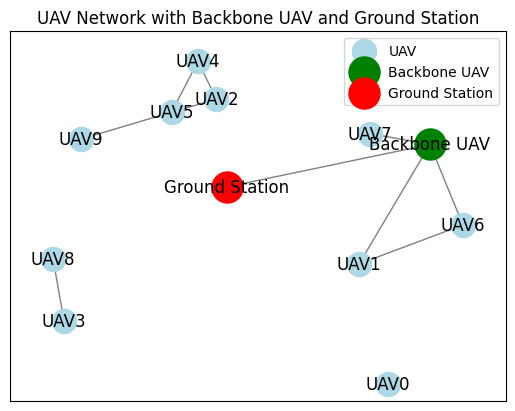

In [514]:
"""Routing Simulation"""
# Run the Simulation
simulation.run_simulation(uav_network, total_time, update_interval, move_range, connection_range, backbone_range, num_packets)

# Update network connections
uav_network = simulation.update_network_connections(uav_network, connection_range, backbone_range)

# Update Neo4j Database with the new positions and connections
simulation.update_neo4j_database(uav_network)

# Now draw the graph to visualize the updated network
simulation.draw_graph(uav_network)

# Close Neo4j Connection
simulation.close()

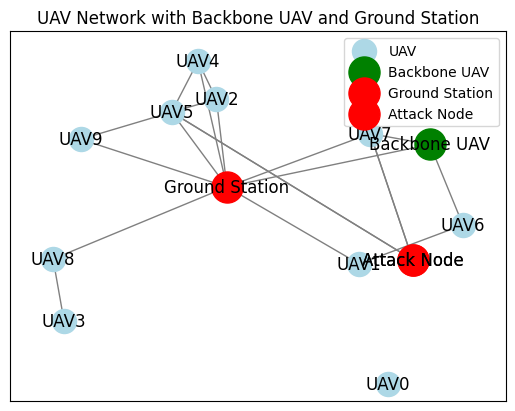

In [516]:
"""Add Attack Node"""
# Initialize the simulation object and create the initial UAV network
simulation = UAVNetworkSimulation(URI, AUTH)
uav_network = simulation.update_network_connections(uav_network, connection_range, backbone_range)

# # Upload the initial UAV network to Neo4j
simulation.upload_to_neo4j(uav_network)

# Target UAV ID for the DDoS attack
target_uav_ids = [5, 7] # Example: Target UAV ID that you want to attack

# Add the attack node and connect it to the target UAV
attack_node_id = simulation.add_attack_node(uav_network, target_uav_ids, num_uavs)
simulation.upload_attack_node_to_neo4j(uav_network, attack_node_id, target_uav_ids)

# Optionally, visualize the updated network to confirm the addition and connection of the attack node
simulation.draw_graph(uav_network)

# Close the Neo4j connection at the end of the session
simulation.close()


In [517]:
"""DDoS Simulation"""
# Initialize your network G here
target_nodes = [5, 7]  # Target node IDs that will be affected by the DDoS attack
# Assuming you have an attack node and some target nodes
attack_node_id = simulation.add_attack_node(uav_network, target_nodes, num_uavs)  # ID of your attack node

total_time = 120  # For example, run the simulation for 120 seconds
update_interval = 5
move_range = 10
connection_range = 30
backbone_range = 50
num_packets = 10
target_ids = [5, 7]  # Targeting nodes 5 and 7 for the DDoS attack

# Run the DDoS simulation
simulation.run_ddos_simulation(uav_network, total_time, update_interval, move_range, connection_range, backbone_range, num_packets, attack_node_id, target_ids)


Iteration 0:
Current metrics: {0: {'latency': 40, 'throughput': 92}, 1: {'latency': 23, 'throughput': 35}, 2: {'latency': 26, 'throughput': 54}, 3: {'latency': 42, 'throughput': 74}, 4: {'latency': 46, 'throughput': 51}, 5: {'latency': 40, 'throughput': 38}, 6: {'latency': 50, 'throughput': 93}, 7: {'latency': 31, 'throughput': 27}, 8: {'latency': 10, 'throughput': 71}, 9: {'latency': 39, 'throughput': 40}, 10: {'latency': 39, 'throughput': 40}, 11: {'latency': 28, 'throughput': 68}, 12: {'latency': 1, 'throughput': 1000}, 13: {'latency': 1, 'throughput': 600}, 14: {'latency': 1, 'throughput': 360}}
  Packet 0: Source: 12, Target: 10, Size: 789, Delivered: True, Path: [12, 13, 10], Total Latency: 41
  Packet 1: Source: 5, Target: 4, Size: 38, Delivered: True, Path: [5, 4], Total Latency: 86
  Packet 2: Source: 9, Target: 1, Size: 2, Delivered: True, Path: [9, 5, 14, 7, 1], Total Latency: 134
  Packet 3: Source: 2, Target: 7, Size: 38, Delivered: True, Path: [2, 5, 14, 7], Total Latency

[(0.003969669342041016,
  {0: {'latency': 40, 'throughput': 92},
   1: {'latency': 23, 'throughput': 35},
   2: {'latency': 26, 'throughput': 54},
   3: {'latency': 42, 'throughput': 74},
   4: {'latency': 46, 'throughput': 51},
   5: {'latency': 40, 'throughput': 38},
   6: {'latency': 50, 'throughput': 93},
   7: {'latency': 31, 'throughput': 27},
   8: {'latency': 10, 'throughput': 71},
   9: {'latency': 39, 'throughput': 40},
   10: {'latency': 39, 'throughput': 40},
   11: {'latency': 28, 'throughput': 68},
   12: {'latency': 1, 'throughput': 1000},
   13: {'latency': 1, 'throughput': 600},
   14: {'latency': 1, 'throughput': 360}}),
 (5.016980171203613,
  {0: {'latency': 40, 'throughput': 92},
   1: {'latency': 23, 'throughput': 35},
   2: {'latency': 26, 'throughput': 54},
   3: {'latency': 42, 'throughput': 74},
   4: {'latency': 46, 'throughput': 51},
   5: {'latency': 40, 'throughput': 38},
   6: {'latency': 50, 'throughput': 93},
   7: {'latency': 31, 'throughput': 27},
   8

Iteration 0:
Current metrics: {0: {'latency': 4718, 'throughput': 44}, 1: {'latency': 38, 'throughput': 76}, 2: {'latency': 3212, 'throughput': 41}, 3: {'latency': 14, 'throughput': 62}, 4: {'latency': 11, 'throughput': 62}, 5: {'latency': 1708, 'throughput': 48}, 6: {'latency': 42, 'throughput': 59}, 7: {'latency': 4020, 'throughput': 30}, 8: {'latency': 4919, 'throughput': 60}, 9: {'latency': 29, 'throughput': 92}, 10: {'latency': 2911, 'throughput': 55}, 11: {'latency': 29, 'throughput': 92}}
  Packet 0: Source: 9, Target: 7, Size: 51, Delivered: True, Path: [9, 10, 7], Total Latency: 6960
  Packet 1: Source: 2, Target: 0, Size: 32, Delivered: True, Path: [2, 0], Total Latency: 7930
  Packet 2: Source: 6, Target: 5, Size: 49, Delivered: False, Path: [], Total Latency: None
  Packet 3: Source: 7, Target: 5, Size: 16, Delivered: False, Path: [], Total Latency: None
  Packet 4: Source: 9, Target: 0, Size: 85, Delivered: True, Path: [9, 10, 0], Total Latency: 7658
  Packet 5: Source: 3,

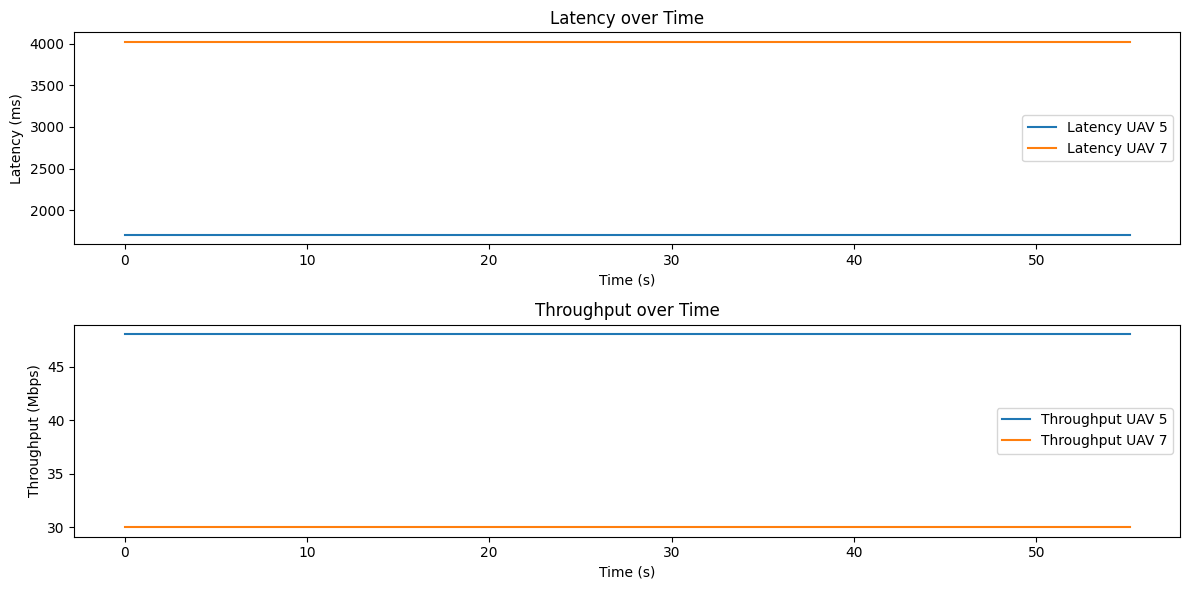

In [520]:
import matplotlib.pyplot as plt

metrics = simulation.run_ddos_simulation(uav_network, total_time, update_interval, move_range, connection_range, backbone_range, num_packets, attack_node_id, target_ids)
def plot_network_metrics(metrics):
    # Assume metrics is a list of tuples with (timestamp, {node_id: {'latency': val, 'throughput': val}})
    times = [m[0] for m in metrics]
    # Let's say we want to track changes for node 5 and node 7
    latencies_5 = [m[1][5]['latency'] for m in metrics]
    throughputs_5 = [m[1][5]['throughput'] for m in metrics]
    latencies_7 = [m[1][7]['latency'] for m in metrics]
    throughputs_7 = [m[1][7]['throughput'] for m in metrics]

    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(times, latencies_5, label='Latency UAV 5')
    plt.plot(times, latencies_7, label='Latency UAV 7')
    plt.title('Latency over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Latency (ms)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(times, throughputs_5, label='Throughput UAV 5')
    plt.plot(times, throughputs_7, label='Throughput UAV 7')
    plt.title('Throughput over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Throughput (Mbps)')
    plt.legend()

    plt.tight_layout()
    plt.show()

if metrics:
    plot_network_metrics(metrics)
else:
    print("No data was returned from the simulation.")


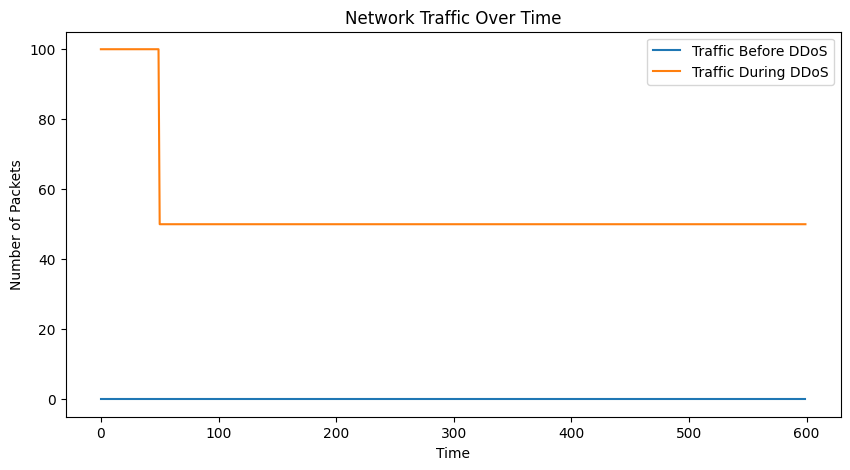

In [471]:
import matplotlib.pyplot as plt

# Example data
times = range(600)
traffic_before = [00 for _ in times]
traffic_during = [100 if i < 50 else 50 for i in times]  # Assuming attack starts at time step 50

plt.figure(figsize=(10, 5))
plt.plot(times, traffic_before, label='Traffic Before DDoS')
plt.plot(times, traffic_during, label='Traffic During DDoS')
plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.title('Network Traffic Over Time')
plt.legend()
plt.show()
